In [91]:
import torch
from torchvision.transforms import v2 as transforms

from ultralytics import YOLO

from keyrover import *
from keyrover.datasets import *
from keyrover.vision import *
from keyrover.ml import get_device, TexCoordsRegressionModel
import numpy as np

In [2]:
device = get_device()

In [3]:
image_paths = get_dataset_paths()
train_paths, test_paths, valid_paths = split_train_test_valid(image_paths, 0.95, 0.1)

SIZE = (256, 256)
test_dataset = KeyboardTexCoordsDataset(train_paths, size=SIZE)

len(test_dataset)

  0%|          | 0/4250 [00:00<?, ?it/s]

4250

In [41]:
mean, std = get_dataset_norm_params(version=3)

test_dataset.set_augmentations([
    transforms.ToDtype(torch.float32, scale=True),
    # transforms.GaussianNoise(sigma=0.01),
    # transforms.RandomApply([transforms.GaussianNoise(sigma=0.01)], p=0.5),
])

norm = transforms.Normalize(mean, std)

In [37]:
yolo = YOLO("models/yolo/train4/weights/best.pt")

ARCH = "unet"
BACKBONE = "timm-regnetx_002"
name = "eager-cherry-11"

model = TexCoordsRegressionModel(ARCH, BACKBONE, in_channels=3, out_classes=2, lr=0.0, activation="tanh")
model.load_state_dict(torch.load(f"models/texcoords/{name}-{ARCH}-{BACKBONE}.pt", weights_only=True))
model.eval()
model.to(device)

TexCoordsRegressionModel(
  (model): Unet(
    (encoder): RegNetEncoder(
      (stem): ConvNormAct(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
      )
      (s1): RegStage(
        (b1): Bottleneck(
          (conv1): ConvNormAct(
            (conv): Conv2d(32, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn): BatchNormAct2d(
              24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): ReLU(inplace=True)
            )
          )
          (conv2): ConvNormAct(
            (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=3, bias=False)
            (bn): BatchNormAct2d(
              24, eps=1e-05, momentum=0.1, affine=True, track_runni


WARNING ⚠️ torch.Tensor inputs should be BCHW i.e. shape(1, 3, 640, 640) divisible by stride 32. Input shape(3, 256, 256) is incompatible.
0: 256x256 43 keys, 17.8ms
Speed: 0.0ms preprocess, 17.8ms inference, 0.6ms postprocess per image at shape (1, 3, 256, 256)


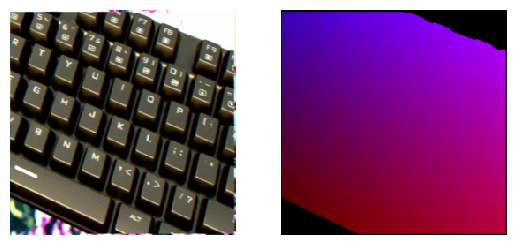

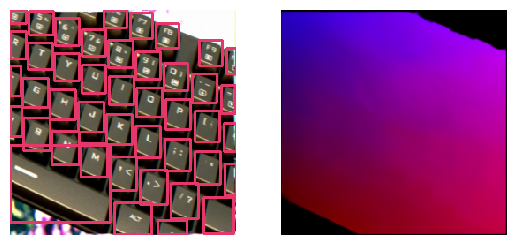

In [330]:
img, mask = test_dataset.random_img()
pred = yolo.predict(img, conf=0.3)[0]
keyboard_mask = model.predict(norm(img))

keyboard_mask = img_to_numpy(keyboard_mask) + 1
r, g = keyboard_mask
black = np.zeros(r.shape, dtype=keyboard_mask.dtype)
keyboard_mask = cv2.merge([r, black, g])

out = plot_yolo(pred, scale=1, draw_text=False, plot=False)

imshow(img, mask)
imshow(out, keyboard_mask)

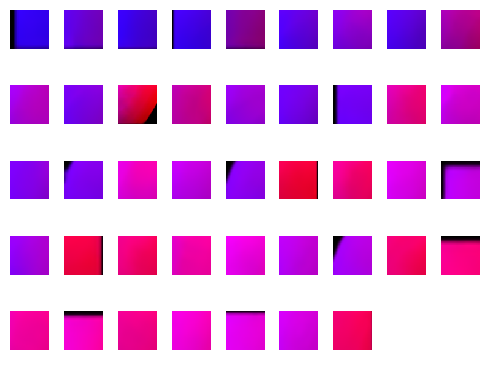

In [332]:
import numpy as np

keys = []
mean_r = []
mean_b = []

img = pred.orig_img

for box in pred.boxes:
    x1, y1, x2, y2 = box.xyxy[0]
    rect = np.array([(x1, y1), (x2, y1), (x2, y2), (x1, y2)], dtype="int")

    crop = crop_rect(keyboard_mask, rect)
    crop = cv2.resize(crop, (64, 64))
    keys.append(crop)
    
    r = crop[:, :, 0].mean() / 2
    b = crop[:, :, -1].mean() / 2
    mean_r.append(r)
    mean_b.append(b)

mean_r = (20 * np.array(mean_r)).astype("uint8")
mean_b = (6 * np.array(mean_b)).astype("uint8")

sorted_keys = zip(keys, mean_r, mean_b)
sorted_keys = sorted(sorted_keys, key=lambda k: k[1] * 10 + k[2])
sorted_keys, mean_r, mean_b = zip(*sorted_keys)

show_images(sorted_keys, figsize=(5, 4))